Shape of the dataset: (96453, 1)
First 10 rows of the dataset:
   Temperature (C)
0         9.472222
1         9.355556
2         9.377778
3         8.288889
4         8.755556
5         9.222222
6         7.733333
7         8.772222
8        10.822222
9        13.772222


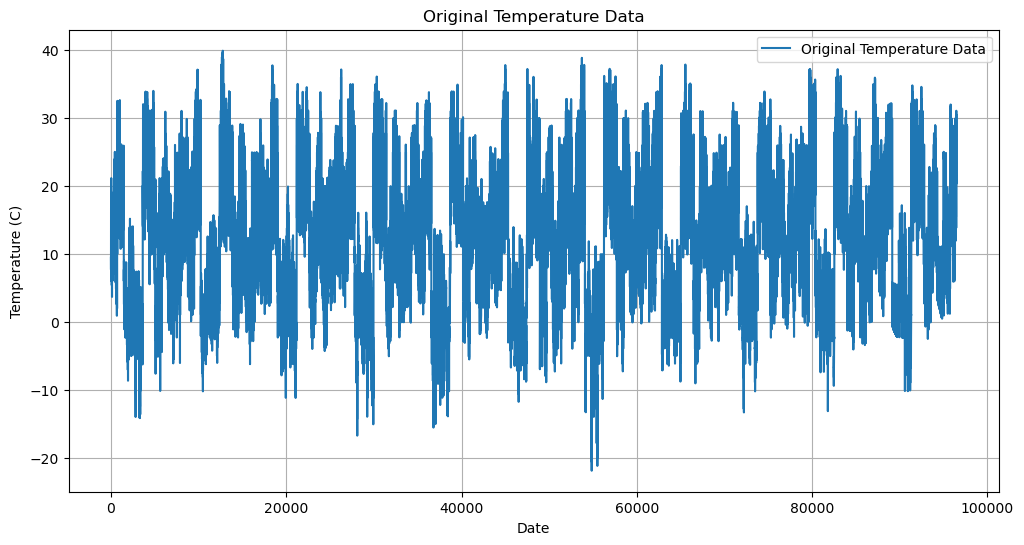

First 10 values of rolling mean (window=5):
 0          NaN
1          NaN
2          NaN
3          NaN
4     9.050000
5     9.000000
6     8.675556
7     8.554444
8     9.061111
9    10.064444
Name: Temperature (C), dtype: float64
First 20 values of rolling mean (window=10):
 0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9      9.557222
10    10.211667
11    10.990556
12    11.832778
13    12.737222
14    13.749444
15    14.718333
16    15.483889
17    16.161667
18    16.505000
19    16.442222
Name: Temperature (C), dtype: float64


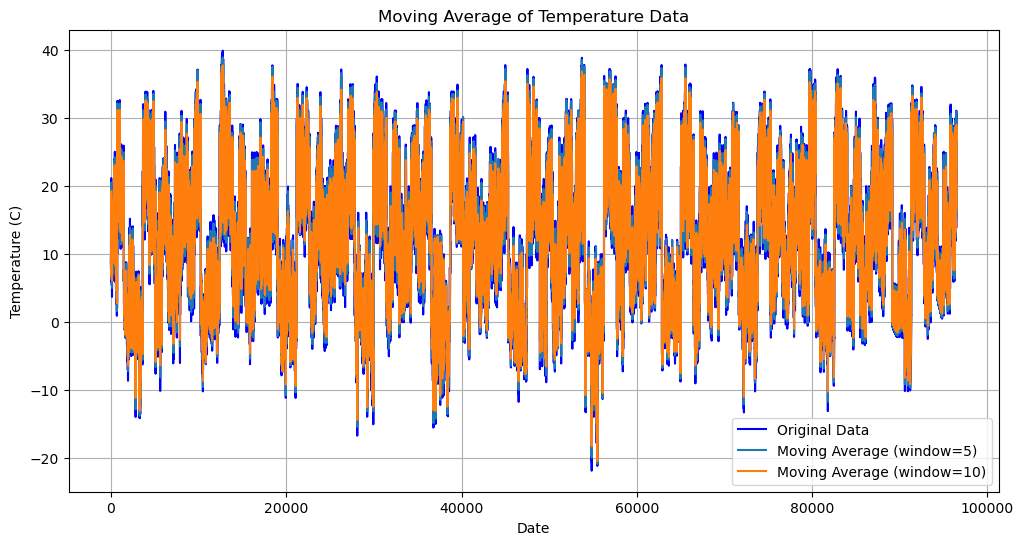

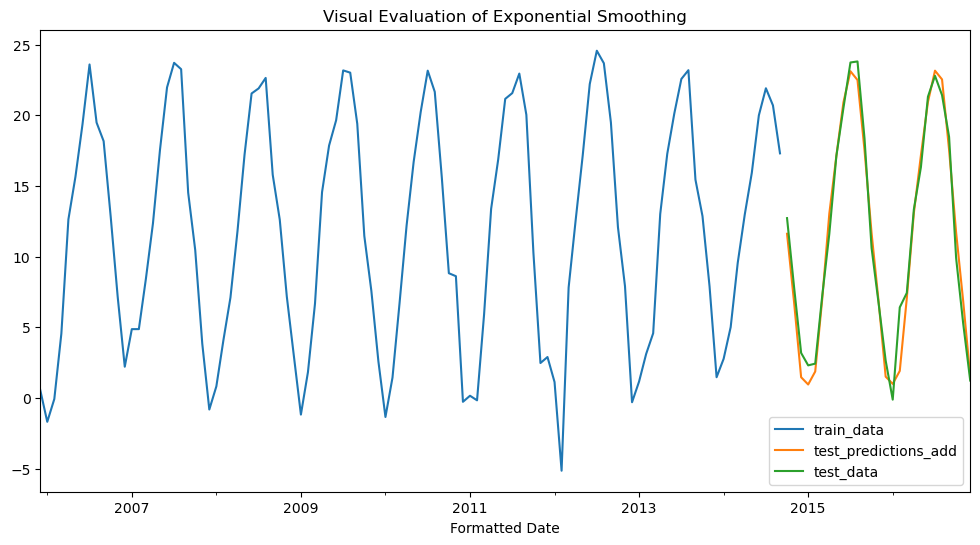

RMSE on Test Data: 1.297114711009848


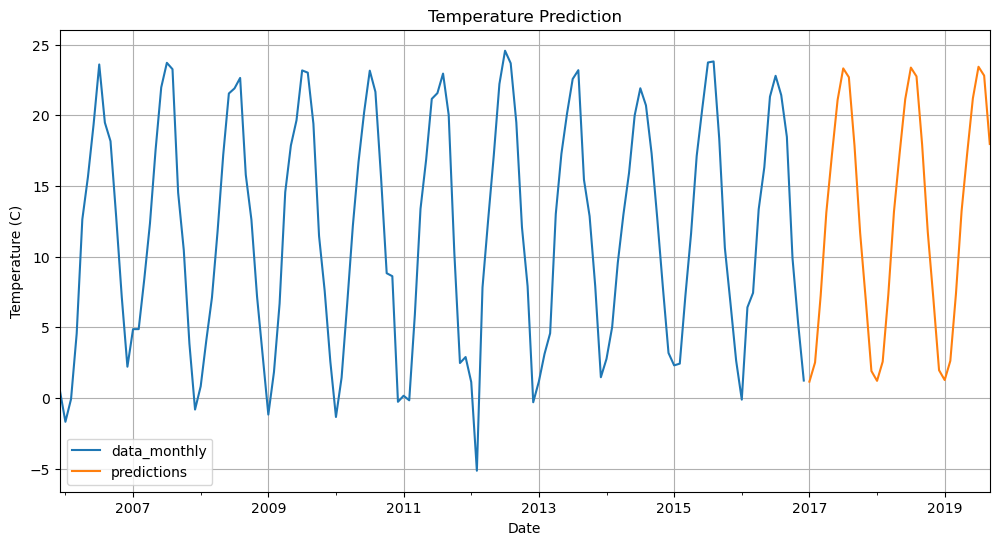

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# Load dataset
# -----------------------------
data = pd.read_csv('weatherHistory.csv')
weather_data = data[['Temperature (C)']]

print("Shape of the dataset:", weather_data.shape)
print("First 10 rows of the dataset:")
print(weather_data.head(10))

# -----------------------------
# Original Data Plot
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(weather_data['Temperature (C)'], label='Original Temperature Data')
plt.title('Original Temperature Data')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# Moving Average
# -----------------------------
rolling_mean_5 = weather_data['Temperature (C)'].rolling(window=5).mean()
rolling_mean_10 = weather_data['Temperature (C)'].rolling(window=10).mean()

print("First 10 values of rolling mean (window=5):\n", rolling_mean_5.head(10))
print("First 20 values of rolling mean (window=10):\n", rolling_mean_10.head(20))

plt.figure(figsize=(12, 6))
plt.plot(weather_data['Temperature (C)'], label='Original Data', color='blue')
plt.plot(rolling_mean_5, label='Moving Average (window=5)')
plt.plot(rolling_mean_10, label='Moving Average (window=10)')
plt.title('Moving Average of Temperature Data')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# Resample monthly mean
# -----------------------------
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], errors='coerce', utc=True)
data.set_index('Formatted Date', inplace=True)
data_monthly = data['Temperature (C)'].resample('MS').mean()

# -----------------------------
# Train-test split (80-20)
# -----------------------------
x = int(len(data_monthly) * 0.8)
train_data = data_monthly[:x]
test_data = data_monthly[x:]

# -----------------------------
# Exponential Smoothing (Additive Trend + Additive Seasonality)
# -----------------------------
model_add = ExponentialSmoothing(
    train_data, 
    trend='add', 
    seasonal='add',  # Use additive seasonality to handle negative temps
    seasonal_periods=12
).fit()

test_predictions_add = model_add.forecast(steps=len(test_data))

ax = train_data.plot(figsize=(12, 6))
test_predictions_add.plot(ax=ax)
test_data.plot(ax=ax)
ax.legend(["train_data", "test_predictions_add", "test_data"])
ax.set_title('Visual Evaluation of Exponential Smoothing')
plt.show()

# -----------------------------
# RMSE on Test Data
# -----------------------------
rmse = np.sqrt(mean_squared_error(test_data, test_predictions_add))
print("RMSE on Test Data:", rmse)

# -----------------------------
# Forecast next 1/4 of the data
# -----------------------------
model_final = ExponentialSmoothing(
    data_monthly, 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12
).fit()

predictions = model_final.forecast(steps=int(len(data_monthly)/4))

ax = data_monthly.plot(figsize=(12, 6))
predictions.plot(ax=ax)
ax.legend(["data_monthly", "predictions"])
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (C)')
ax.set_title('Temperature Prediction')
plt.grid()
plt.show()
